# OFAT SA

In [2]:
%matplotlib inline
from model import *
from agents import *
from globals import *
from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output

fixed_params = {
    "network_type": 1,
    "N": 100,
    "no_of_neighbors": 2,
    #"beta_component": 0.15,
    "similarity_treshold": 0.0,
    "social_influence": 0.0,
    "swingers": 0,
    "malicious_N":0
}

variable_params = {
    #"N": range(100, 20, 50),
    #"no_of_neighbors": range(1, 3),
    "beta_component": np.arange(0.0, 1.0, 0.2),
    #"similarity_treshold": np.arange(0.0, 1.0, 0.5),
    #"social_influence": np.arange(0.0, 1.0, 0.5),
    #"swingers": range(0, 3)
}


# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 5
max_steps = 20

# Set the outputs
model_reporters = {
                "preferences": compute_preferences,
                "opinions": compute_opinions,
                "preference_A": compute_preference_A,
                "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "community_no": community_no,
}

data = {}

  
batch = BatchRunner(Network, 
                    max_steps=max_steps,
                    iterations=replicates,
                    fixed_parameters=fixed_params,
                    variable_parameters=variable_params,
                    model_reporters=model_reporters,
                    display_progress=True)
    
batch.run_all()
data = batch.get_model_vars_dataframe()

#print data
print(data)

25it [00:22,  1.16it/s]

    beta_component  Run  community_no  opinions  preference_A  preference_B  \
0              0.0    0            12      0.44      0.640233      0.570308   
1              0.0    1            12      0.41      0.574105      0.543072   
2              0.0    2            11      0.54      0.619994      0.606758   
3              0.0    3            13      0.33      0.596500      0.556344   
4              0.0    4            11      0.38      0.616805      0.587034   
5              0.2    5            11      0.56      0.543490      0.519348   
6              0.2    6            12      0.35      0.606345      0.692058   
7              0.2    7            12      0.66      0.581675      0.563113   
8              0.2    8            13      0.67      0.584152      0.490269   
9              0.2    9            15      0.63      0.611712      0.517089   
10             0.4   10            12      0.44      0.584451      0.539661   
11             0.4   11            13      0.64     

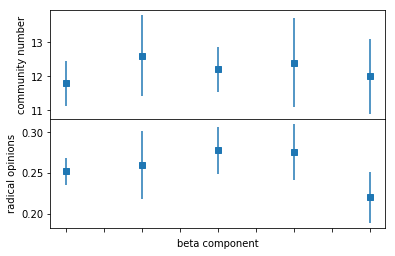

In [3]:
# Example plots for varying beta component

replicates = 5
distinct_samples = 5

beta_component = np.arange(0.0, 1.0, 0.2)

# community number
count=0
list_mean_community_no = []
list_err_community_no = []
for i in range(distinct_samples):
    community_no = []
    for j in range(replicates):
        community_no.append(data.community_no[count + j])
    count = count + j + 1
    mean = np.mean(community_no)
    std = np.std(community_no)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_community_no.append(mean)
    list_err_community_no.append(err)

# radical opinions
count=0
list_mean_radical_opinions = []
list_err_radical_opinions = []
for i in range(distinct_samples):
    radical_opinions = []
    for j in range(replicates):
        radical_opinions.append(data.radical_opinions[count + j])
    count = count + j + 1
    mean = np.mean(radical_opinions)
    std = np.std(radical_opinions)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_radical_opinions.append(mean)
    list_err_radical_opinions.append(err)


ax1 = plt.subplot(211, xticklabels=[])
plt.errorbar(beta_component, list_mean_community_no, yerr=list_err_community_no, marker='s', linestyle='None')
plt.ylabel('community number')

ax2 = plt.subplot(212, sharex = ax1)
plt.errorbar(beta_component, list_mean_radical_opinions, yerr=list_err_radical_opinions, marker='s', linestyle='None')
plt.xlabel('beta component')
plt.ylabel('radical opinions')

plt.subplots_adjust(hspace=.0)
plt.show()

# Sobol SA

I also tried sobol sensitivity analysis, but this doesn't work (yet)...

In [1]:
#### %matplotlib inline
from model import *
from agents import *
from globals import *
from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pathos
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time

# We define our variables and bounds

fixed_params = {
    "network_type": 1
}

problem = {
    'num_vars': 4,
    'names': ['no_of_neighbors', 'similarity_treshold', 'social_influence', 'swingers'],
    'bounds': [[2, 5], [0.01, 1.0], [0.01, 1.0], [1, 5]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
max_steps = 100
distinct_samples = 5

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)
# print(param_values)

# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
                "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions
#                 "community_no": community_no,
}


# BatchRunner
batch = BatchRunnerMP(Network, 
                    max_steps=max_steps,
                    fixed_parameters=fixed_params,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters, nr_processes=8)
times = []
count = 0
for i in range(replicates):
    for vals in param_values:
        start = time.time()
        # Change parameters that should be integers
        vals = list(vals)
#         vals[2] = int(vals[2])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        variable_parameters['network_type']=1
        variable_parameters['malicious_N']=0
        variable_parameters['N']=1000
        variable_parameters['beta_component']=0.23
        variable_parameters['no_of_neighbors']=int(variable_parameters['no_of_neighbors'])
        variable_parameters['swingers']=int(variable_parameters['swingers'])
#         print(variable_parameters)
#         print(variable_parameters)
        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
        times.append(time.time() - start)
        meantime = np.mean(times)
        print('Average duration per iteration: '+ str(meantime)+ ' seconds.')
        nectime = ((len(param_values) * (replicates))-count)*meantime
        print('Expected time till finish: ', int(nectime/3600), 'hours and ', int((nectime%3600)/60), ' minutes.')
        
        
    
data = batch.get_model_vars_dataframe()
print(data)

0.60% done
Average duration per iteration: 13.480236093203226 seconds.
Expected time till finish:  3 hours and  43  minutes.


Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-24:
Process ForkPoolWorker-11:
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-22:
Process ForkPoolWorker-4:
Process ForkPoolWorker-13:
Process ForkPoolWorker-1:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
  File "/usr/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap


  File "/usr/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/usr/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/usr/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.7/site-packages/multiproc

KeyboardInterrupt: 

In [ ]:
community_number = sobol.analyze(problem, data['community_no'].as_matrix(), print_to_console=True)
radical_opinions = sobol.analyze(problem, data['radical_opinions'].as_matrix(), print_to_console=True)

In [ ]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

In [ ]:
for Si in (community_number, radical_opinions):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Second order
    plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()